<center><h1>Introduction to ggplot2</h1></center>

# 1. What is _ggplot2_?

  - Hugely popular R package for visualization 
  - Authored by Hadley Wickham (of _dplyr_ and _tidyverse_ fame)
  - Implements the "grammar-of-graphics" design philosophy (hence "gg")
  - Easily produces beautiful and informative visualizations

# 2. Plotting Person-Level Characteristics in Arrests

  - The Pvd arrests data are at the _violation_-level
  - We want person-level data on the invdividuals arrested
  - This "_level-of-analysis_" or "_level-of-granularity_" problem is ubiquitous 

# 3. Generating Person-Level Data
  - We are aggregating "up" from the violation level
  - Will use the `group_by()` and `summarise()` idiom

In [2]:
# Load necessary packages
library(stringr)
library(dplyr)
library(ggplot2)

arrests_df <- read.csv("./data/pvd_arrests_2020-10-03.csv")


## 3.1 Computing Number of Officers (correctly)

  - First, need to determine if `arresting_officers` is in _full-name_-format or _first-initial_-format

In [3]:
is_uppercase <- function(chr) {
    res <- chr %in% LETTERS
    return(res)
}

has_full_names <- function(names_str) {
    char1 <- substr(names_str, 1, 1)
    char2 <- substr(names_str, 2, 2)
    
    res <- !(is_uppercase(char1) && is_uppercase(char2))
    return(res)
}

### 3.1.1 Couting the Names 
  - Want to correct count names regardless of format
  - Update our `count_names()` function

In [5]:
count_names <- function(names_str) {
    names_str_trm <- str_trim(names_str)     # remove whitespace
    
    if (has_full_names(names_str_trm)) {
        split_char <- "/ "
    } else {
        split_char <- ", "
    }
    
    name_vec <- unlist(str_split(names_str_trm, split_char))
    k <- length(name_vec)
    
    return(k)
}

### 3.1.2 Counting Officers (correctly)
  - Note the sequence of function calls:
    + `count_officers()` => `count_names()` => `has_full_names()` => `is_uppercase()`

In [6]:
count_officers <- function(col) {

    n <- length(col)   # get the length of our input column
    cnts <- rep(0, n)  # allocate vector of zeros to populate with counts

    for (i in 1:n) {
        cnts[i] <- count_names(col[i])
    }
    return(cnts) 
}

In [7]:
arrests_df$officer_cnt <- count_officers(arrests_df$arresting_officers)

## 3.2 Add Violent Offense Flag

In [8]:
# Write function to flag alleged violent crimes from the 
# description of of the statute violation

is_violent_offense <- function(v) {

    violent_terms <- c("domestic-asslt", "assault", "battery", "murder")
    n_obs <- length(v)
    is_violent <- rep(FALSE, n_obs)
    
    # iterate over all statute descriptions
    for (i in 1:n_obs) {
        
        # iterate over the 4 terms associated with violence
        for (term in violent_terms) {
            if (!is.na(v[i]) && str_detect(tolower(v[i]), term)) {

                is_violent[i] <- TRUE
            }
        }
    }
    return(is_violent)
}

### 3.2.1 Test our Function (always!!)

In [9]:
vio_vec <- c("DISORDERLY CONDUCT", 
             "RESISTING LEGAL OR ILLEGAL ARREST",
             "DOMESTIC-SIMPLE ASSAULT/BATTERY", 
             "SIMPLE ASSAULT OR BATTERY")

is_violent_offense(vio_vec)    # Should be: FALSE, FALSE, TRUE, TRUE

[1] FALSE FALSE  TRUE  TRUE

### 3.2.2 Create `violent` Column in `arrests_df`

In [10]:
arrests_df$violent <- is_violent_offense(arrests_df$statute_desc)

In [12]:
head(arrests_df)

,arrest_date,year,month,gender,race,ethnicity,year_of_birth,age,from_address,from_city,from_state,statute_type,statute_code,statute_desc,counts,case_number,arresting_officers,arrestee_id,officer_cnt,violent
,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<lgl>
1,2019-08-24T02:23:00.0,2019,8,Male,White,NonHispanic,1981,37,No Permanent Address,providence,Rhode Island,,,,NA,2019-00084142,"YGonzalez, LTaveras",pvd2218242150382148273,2,FALSE
2,2019-08-24T02:02:00.0,2019,8,,,,1994,25,SUMMER AVE,Cranston,Rhode Island,RI Statute Violation,31-11-18,"Driving after Denial, Suspension or Revocation of License",1,2019-00084127,NManfredi,pvd15166785558364246202,1,FALSE
3,2019-08-24T02:02:00.0,2019,8,Female,Black,NonHispanic,1984,34,DOUGLAS AVE,Providence,Rhode Island,RI Statute Violation,12-7-10,RESISTING LEGAL OR ILLEGAL ARREST,1,2019-00084126,"MPlace, JPerez, ASantos",pvd3142917706201385905,3,FALSE
4,2019-08-24T02:02:00.0,2019,8,Female,Black,NonHispanic,1984,34,DOUGLAS AVE,Providence,Rhode Island,RI Statute Violation,11-45-1,DISORDERLY CONDUCT,1,2019-00084126,"MPlace, JPerez, ASantos",pvd3142917706201385905,3,FALSE
5,2019-08-24T02:02:00.0,2019,8,Female,Black,Unknown,2001,18,TRASH ST,,,RI Statute Violation,12-7-10,RESISTING LEGAL OR ILLEGAL ARREST,1,2019-00084126,"MPlace, JPerez, ASantos",pvd460449304532374599,3,FALSE
6,2019-08-24T02:02:00.0,2019,8,Female,Black,Unknown,2001,18,TRASH ST,,,RI Statute Violation,11-45-1,DISORDERLY CONDUCT,1,2019-00084126,"MPlace, JPerez, ASantos",pvd460449304532374599,3,FALSE


## 3.3 Aggregating to _Person-Level_ DataFrame

  - Use the `group_by()` and `summarise()` pattern from _dplyr_ functions

In [14]:
person_df <- arrests_df %>%
    group_by(arrestee_id) %>%
    summarise(
        total_charges = n(),
        num_uniq_arrests = length(unique(case_number)),
        prop_violent = mean(violent),
        mean_officer_cnt = mean(officer_cnt),
        age = age[1],
        gender = gender[1]
    ) 

`summarise()` ungrouping output (override with `.groups` argument)



In [15]:
head(person_df)

arrestee_id,total_charges,num_uniq_arrests,prop_violent,mean_officer_cnt,age,gender
<chr>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
pvd10005240635544439514,2,1,0,1.000000,21,Female
pvd10007039892056892673,1,1,0,1.000000,32,Female
pvd10015003399035869819,6,2,0,4.000000,40,Female
pvd10015761183771579680,1,1,0,2.000000,42,Male
pvd10016651127192901464,1,1,1,2.000000,30,Male
pvd10028326204653807523,3,3,0,1.666667,31,Male


# 4. Intro to _ggplot2_
  - Operates on `data.frame` objects
  - Map variables to aesthetics, and then display using "geom" (i.e., "geometric object")
  - Geom layers can be stack over one another to add information

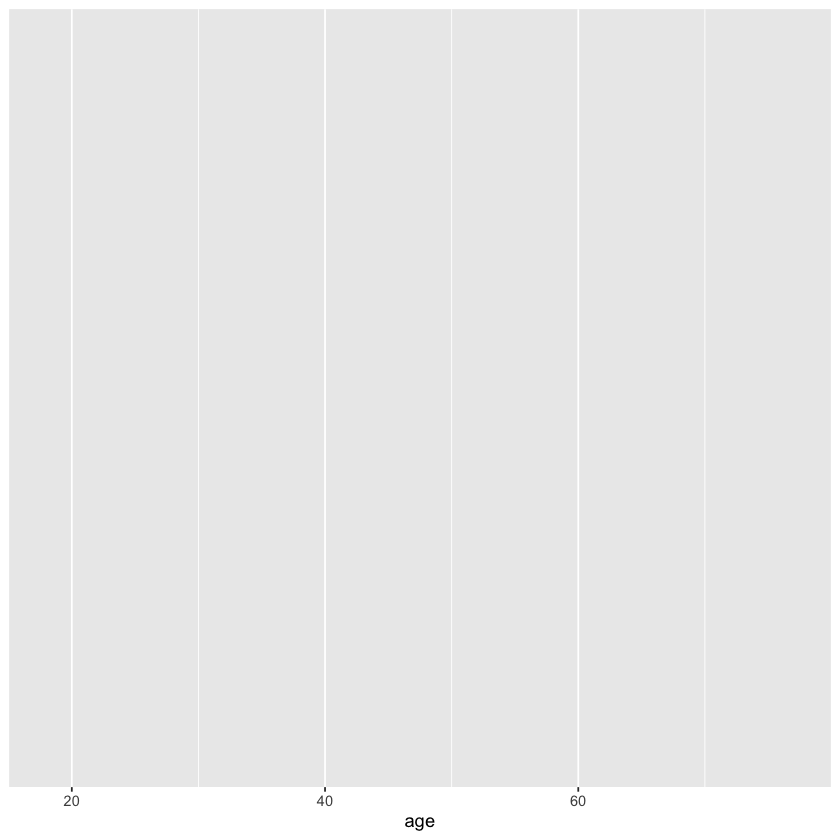

In [16]:
ggplot(person_df, aes(x = age))    # does nothing...

## 4.1 Plotting Histogram of `age`

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



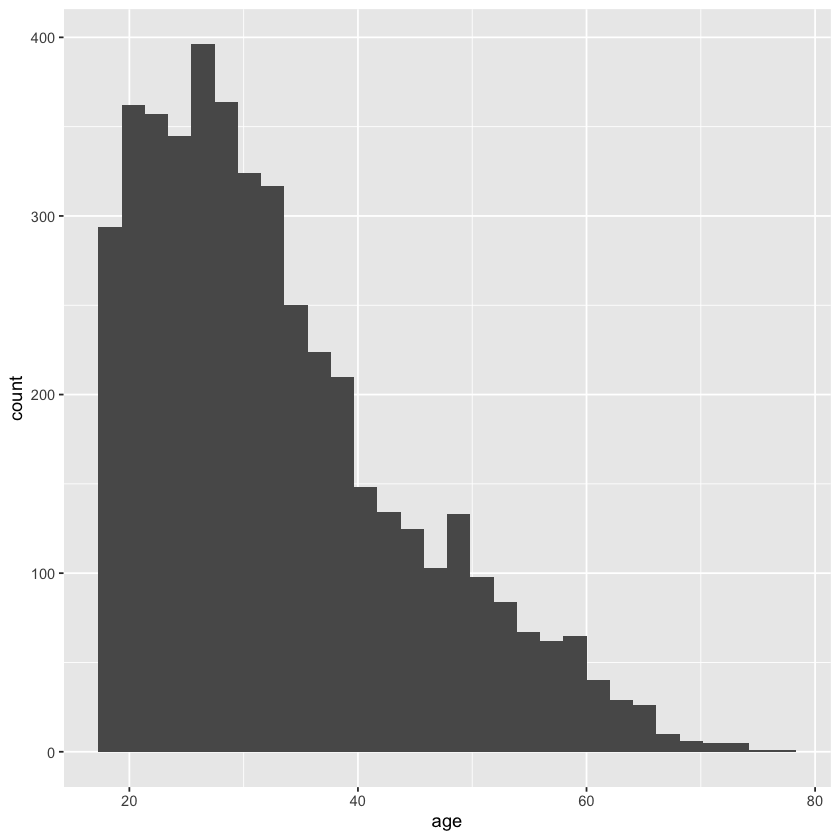

In [17]:
ggplot(person_df, aes(x = age)) +
    geom_histogram()   # kinda boring...

### 4.1.1 Adding `colour` and `fill` to `geom_histogram()`

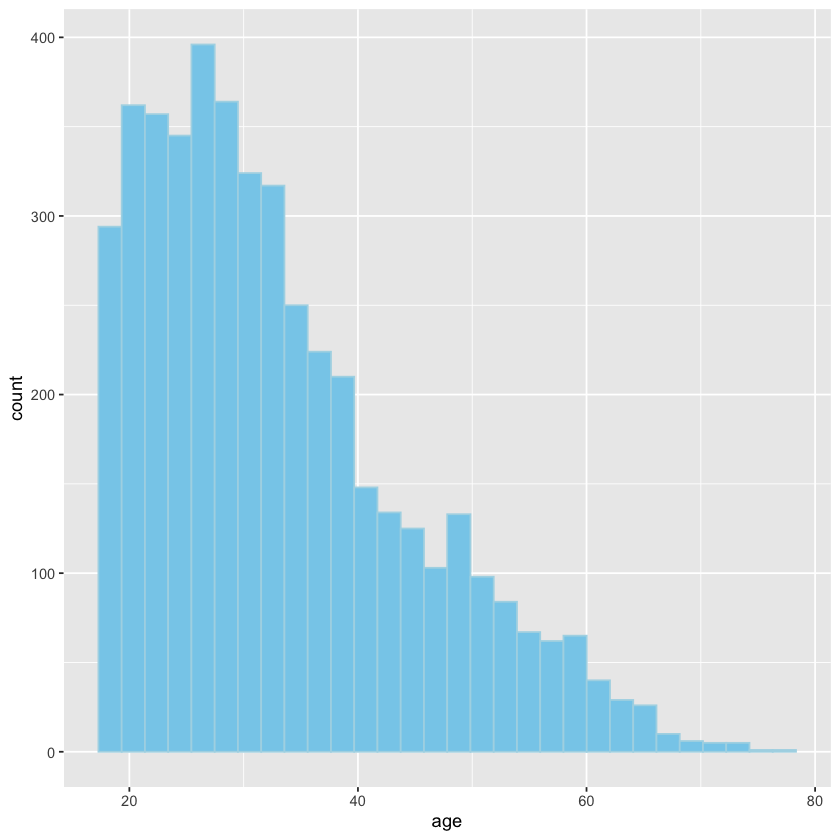

In [19]:
ggplot(person_df, aes(x = age)) +
    geom_histogram(fill = "skyblue", colour = "lightblue", bins = 30)

## 4.2 Density Plot of `age`

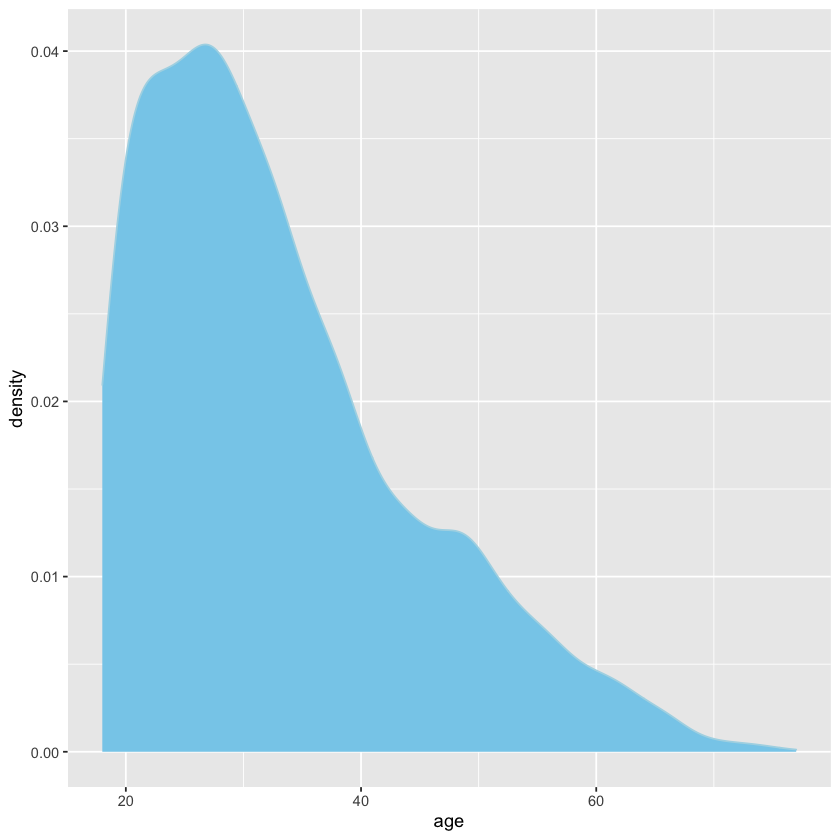

In [21]:
ggplot(person_df, aes(x = age)) +
    geom_density(fill = "skyblue", colour = "lightblue")  

### 4.2.1 Adjusting `alpha`

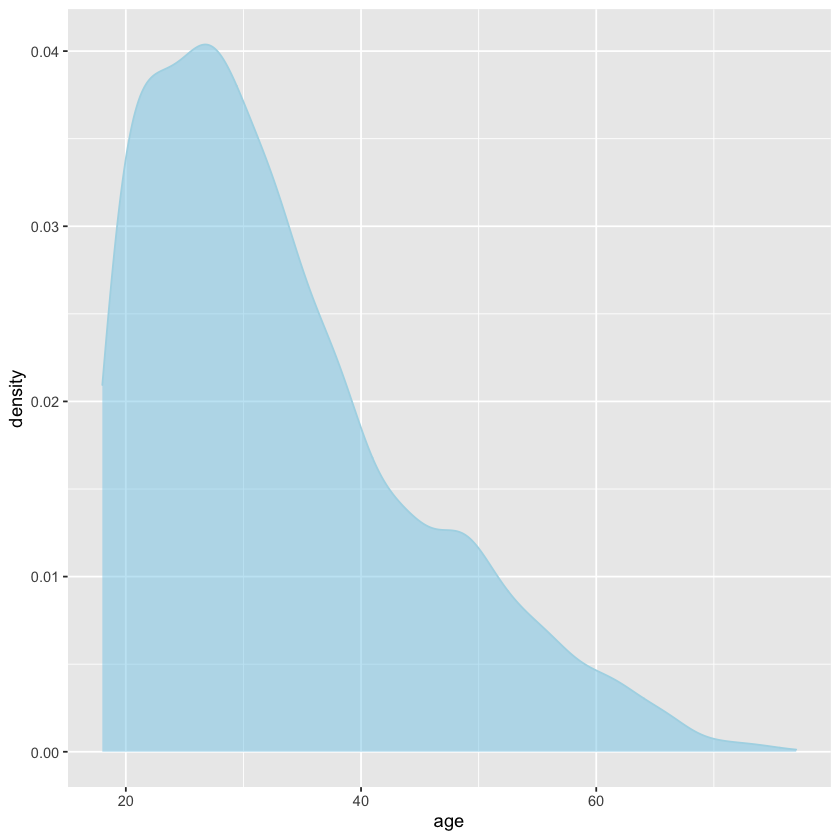

In [22]:
ggplot(person_df, aes(x = age)) + 
    geom_density(fill = "skyblue", colour = "lightblue", alpha = 0.5)

### 4.2.2 Adding `gender` Variable Aesthetic

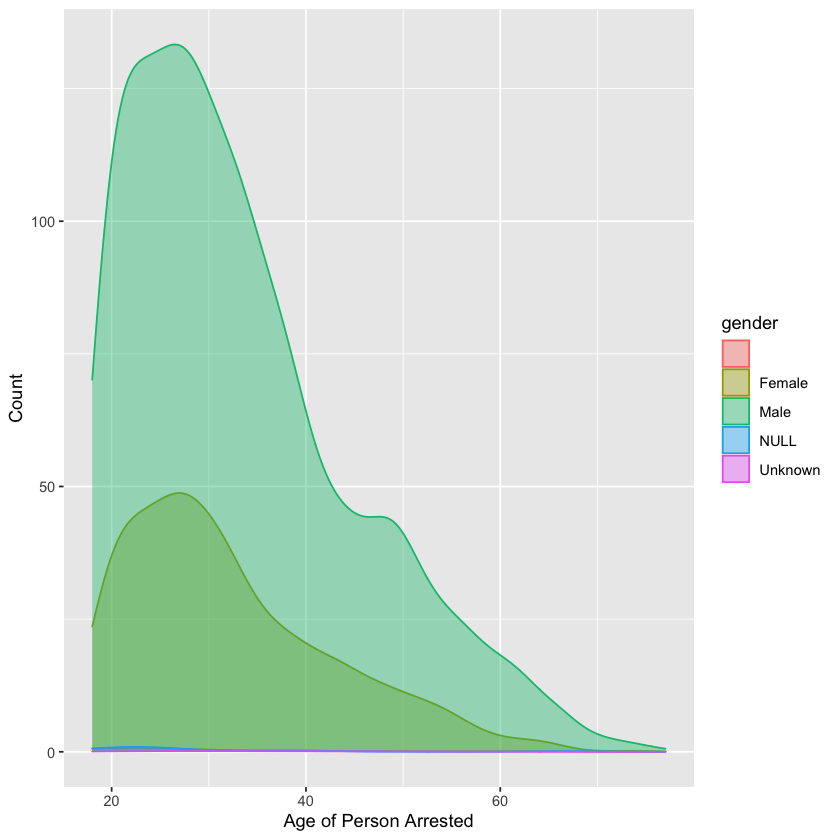

In [23]:
ggplot(person_df, aes(x = age, y = stat(count), fill = gender, colour = gender)) +
    geom_density(alpha = 0.4) +
    xlab("Age of Person Arrested") +
    ylab("Count")

## 4.3 Scatter Plot of `age` and `total_charges` 

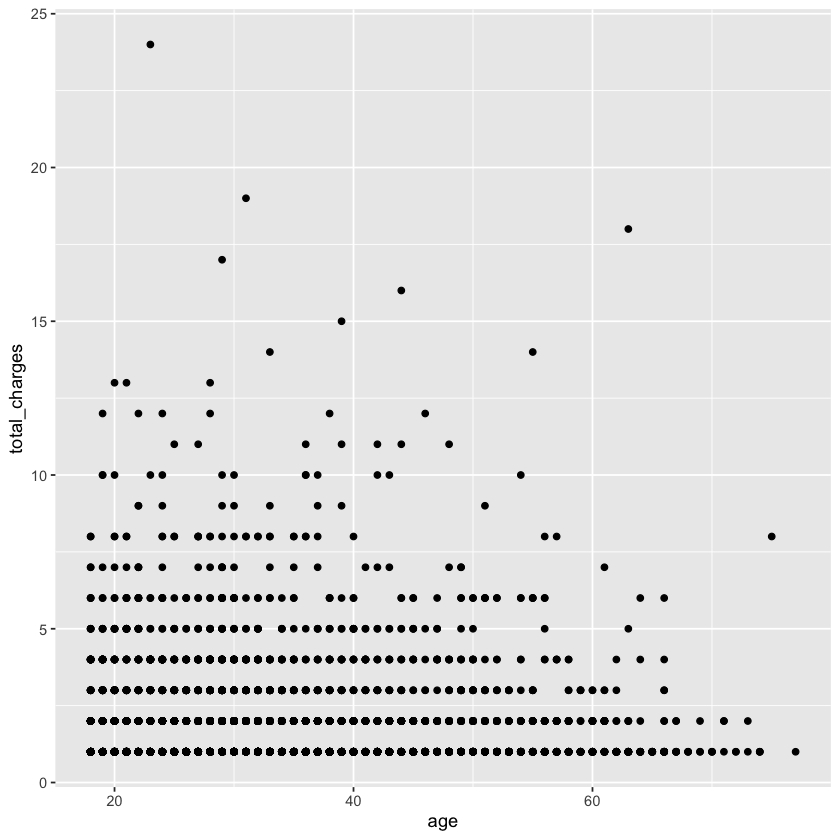

In [24]:
ggplot(person_df, aes(x = age, y = total_charges)) + 
    geom_point()

### 4.3.1 Adjusting `colour` and `alpha`

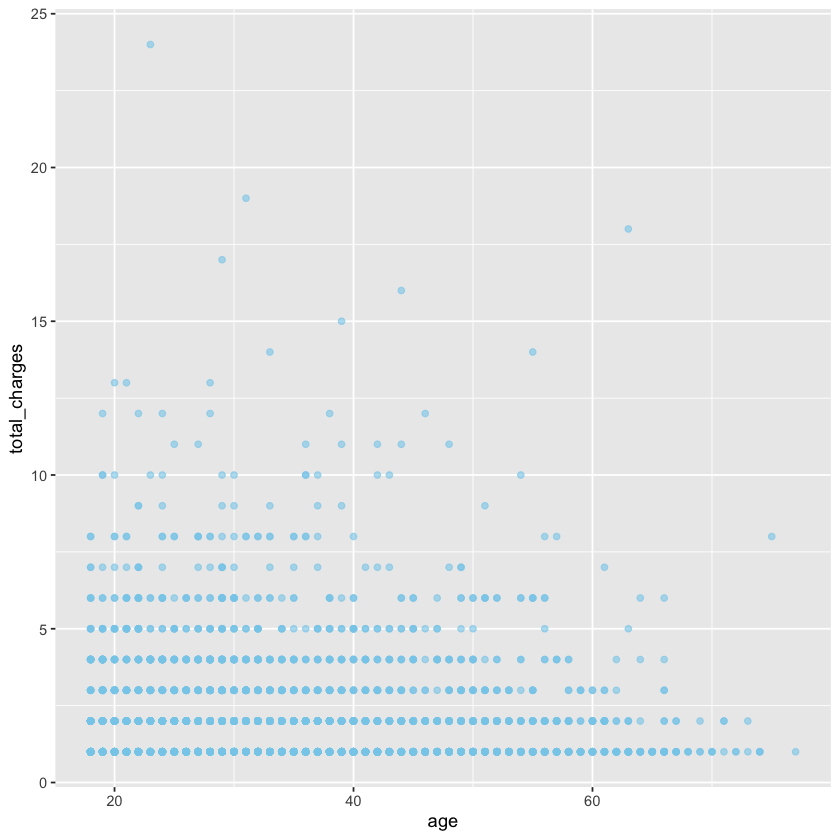

In [25]:
ggplot(person_df, aes(x = age, y = total_charges)) +
    geom_point(colour = "skyblue", alpha = 0.6)

### 4.3.2 Using `geom_jitter` for Scatterplots

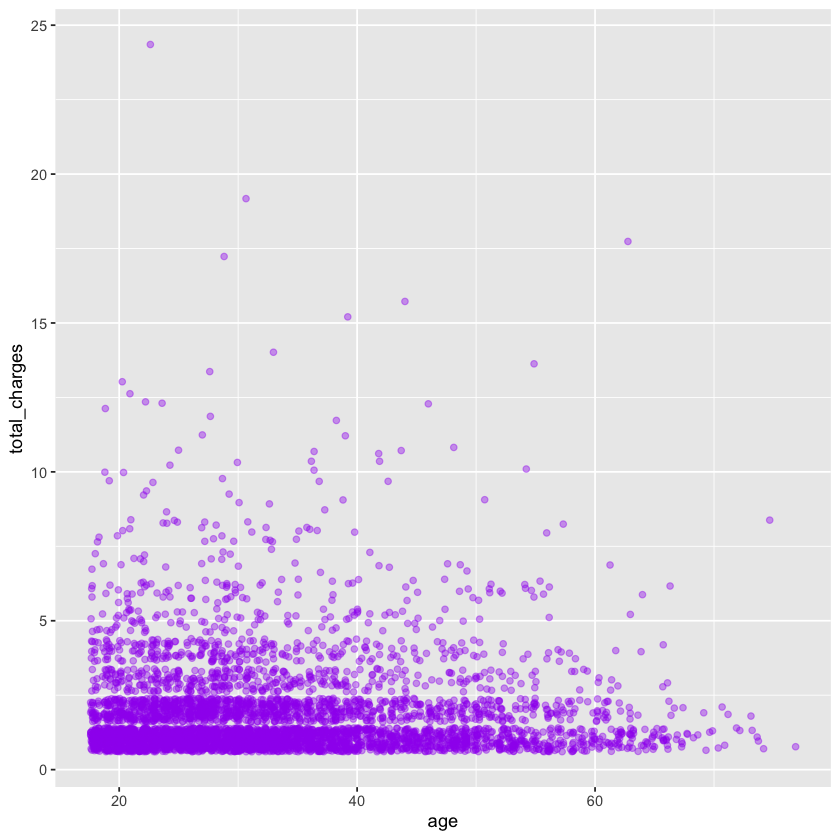

In [30]:
ggplot(person_df, aes(x = age, y = total_charges)) +
    geom_jitter(colour = "purple", alpha = 0.4) 

## 4.4 Plotting `num_uniq_arrests` and `total_charges` with a `stat_smooth()` Layer

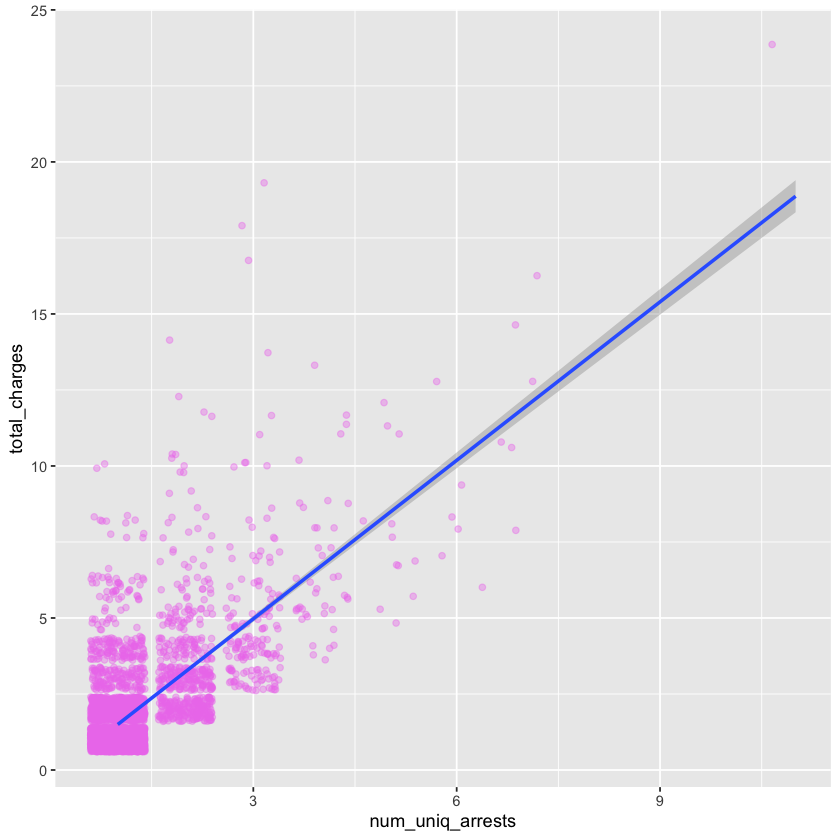

In [31]:
ggplot(person_df, aes(x = num_uniq_arrests, y = total_charges)) +
    geom_jitter(colour = "violet", alpha = 0.4) +
    stat_smooth(method = "lm", formula = y ~ x)

## 4.5 Adding Third Variable to `aes()`

Warning message:
“Removed 2585 rows containing missing values (geom_point).”


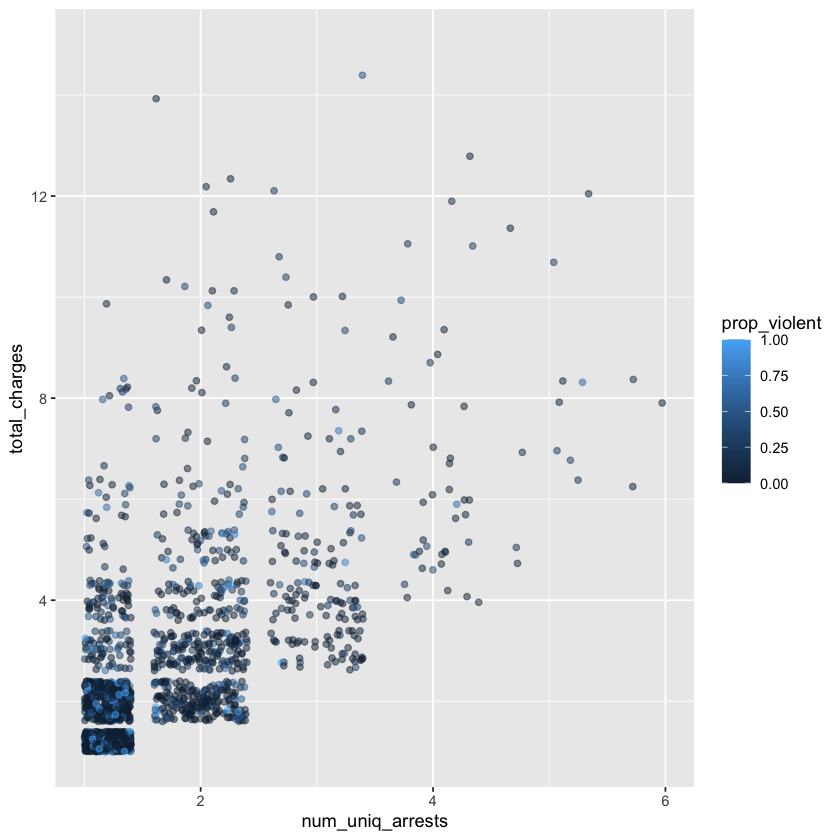

In [33]:
ggplot(person_df, aes(x = num_uniq_arrests, y = total_charges, colour = prop_violent)) +
    geom_jitter(alpha = 0.5) + 
    xlim(1, 6) +
    ylim(1, 15)